In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!nvidia-smi

Mon May 11 14:26:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Dataset prepared for Pytorch Pipeline


In [3]:
!gdown --id 1cV2bDv5h0_wS7fANNdQPWM40hE3PyWls
!unzip springfield_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: springfield_dataset/train/ned_flanders/pic_1398.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1399.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1400.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1401.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1402.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1403.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1404.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1405.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1406.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1407.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1408.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1409.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1410.jpg  
  inflating: springfield_dataset/train/ned_flanders/pic_1411.jpg  
  inflating

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [5]:
!ls springfield_dataset/

characters_illustration.png  sample_submission.csv  train
make_val.py		     testset		    val


Create Training and Validation sets.

Prepare input images.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'springfield_dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
print(dataloaders)
print(dataset_sizes)
print(class_names)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fbfd588d6a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fbf6e6b3f28>}
{'train': 18857, 'val': 2076}
['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


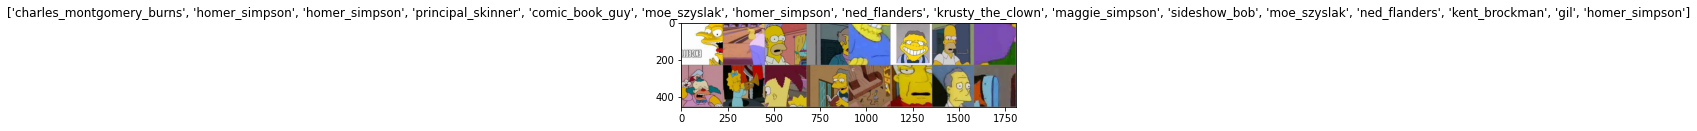

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training function of the model with the given parameters

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

***************************
**TRAIN**

Optional step, you can **skip** because the next step contains trained weights.

Transfer learning was used.

Pretrained **resnext50_32x4d** has been trained for 10 epochs. The best parameters were saved in the model.

Parameters will be restored in the next step.

In [0]:
# model_ft = models.resnet18(pretrained=True)
import torchvision.models as models
model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 42)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

***************************

**Recover the weight** and initialize the new resnext50_32x4d model with them.

In [7]:
# Download parameters
!gdown --id 1RB9RbRt1_VlLTuKLaLHtTEXhyn_NRoo7

Downloading...
From: https://drive.google.com/uc?id=1RB9RbRt1_VlLTuKLaLHtTEXhyn_NRoo7
To: /content/resnext.pt
92.6MB [00:00, 223MB/s]


In [8]:
# Initialize a new model with the best parameters restored
model_ft = models.resnext50_32x4d()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 42)
model_ft = model_ft.to(device)

path = F"/content/resnext.pt" 
model_ft.load_state_dict(torch.load(path))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

***************************
Try to improve current results.

This step **didn't bring improvement**. **Skip**


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.3186 Acc: 0.9148
val Loss: 0.0428 Acc: 0.9899

Epoch 1/24
----------
train Loss: 0.3194 Acc: 0.9140
val Loss: 0.0545 Acc: 0.9851

Epoch 2/24
----------
train Loss: 0.2957 Acc: 0.9226
val Loss: 0.0402 Acc: 0.9913

Epoch 3/24
----------
train Loss: 0.3056 Acc: 0.9185
val Loss: 0.0459 Acc: 0.9899

Epoch 4/24
----------
train Loss: 0.2778 Acc: 0.9247
val Loss: 0.0543 Acc: 0.9851

Epoch 5/24
----------
train Loss: 0.2747 Acc: 0.9260
val Loss: 0.0526 Acc: 0.9865

Epoch 6/24
----------
train Loss: 0.2592 Acc: 0.9287
val Loss: 0.0462 Acc: 0.9880

Epoch 7/24
----------
train Loss: 0.2351 Acc: 0.9359
val Loss: 0.0391 Acc: 0.9894

Epoch 8/24
----------
train Loss: 0.2253 Acc: 0.9410
val Loss: 0.0391 Acc: 0.9894

Epoch 9/24
----------


KeyboardInterrupt: ignored

Save the best weights. **Not necessary**

In [0]:
model_save_name = 'resnext.pt'
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(model_ft.state_dict(), path)

***************************

**Validation**

In [0]:
# Iterate over data.
val_preds = np.array([], dtype='int32')
val_labels = np.array([], dtype='int32')
running_corrects = 0

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
   
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    # statistics
    running_corrects += torch.sum(preds == labels.data)
    
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    val_preds = np.concatenate((val_preds, preds), axis=None)
    val_labels = np.concatenate((val_labels, labels), axis=None)

In [17]:
print(val_preds)
print(val_labels)
(unique, counts) = np.unique(val_preds, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[16 15  2 ...  7 37  6]
[16 15  2 ...  7 37  6]
[[  0  91]
 [  1   4]
 [  2  61]
 [  3  10]
 [  4 134]
 [  5   9]
 [  6 119]
 [  7  97]
 [  8   4]
 [  9  46]
 [ 11  44]
 [ 12   2]
 [ 13   2]
 [ 14  11]
 [ 15 226]
 [ 16  49]
 [ 17 120]
 [ 18  31]
 [ 20 134]
 [ 21  12]
 [ 22 128]
 [ 23   9]
 [ 24  25]
 [ 25 109]
 [ 26   1]
 [ 27 149]
 [ 28 146]
 [ 29  34]
 [ 30   3]
 [ 31   7]
 [ 32 118]
 [ 33   6]
 [ 34   3]
 [ 35   8]
 [ 36  10]
 [ 37  87]
 [ 38   4]
 [ 39   5]
 [ 41  18]]


In [18]:
from sklearn.metrics import f1_score
print(f1_score(val_labels, val_preds, average='micro'))
print(f1_score(val_labels, val_preds, average='macro'))
print(f1_score(val_labels, val_preds, average='weighted'))

0.9894026974951831
0.9086346522934735
0.988714637298817


***************************

**Test** 

In order not to take risks with the final results, the pipeline DLS is used

In [20]:
# Download label_encoder
!gdown --id 15UI2ogJbAP2u04AKKj8byqqv1SPCbbGi

Downloading...
From: https://drive.google.com/uc?id=15UI2ogJbAP2u04AKKj8byqqv1SPCbbGi
To: /content/label_encoder.pkl
100% 4.30k/4.30k [00:00<00:00, 7.42MB/s]


In [0]:
import pickle
from pathlib import Path

TEST_DIR = Path('/content/springfield_dataset/testset/testset')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [22]:
print(len(test_files))

991


In [0]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Make predictions

**The final Test Result**: 0.99468

**Kaggle Nickname**: Mezga_Alexander_35630269

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [0]:
probs = predict(model_ft, test_loader)

In [0]:
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

Create submission and save to the Drive

In [0]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('/content/drive/My Drive/DLS_Hometask/resnet_baseline_2.csv', index=False)